# Viés de Popularidade em Sistemas de Recomendação

---

## Tabela de Conteudos

0. [Download do Dataset](#0.-Download-do-Dataset-)

1. [Carregando e Visualizando o Dataset](#1.-Carregando-e-visualizando-o-dataset)

2. [Divisão da Base em Treino e teste](#2.-Divisão-da-base-em-treino-e-teste)

3. [Visualizando a curva de popularidade do dataset](#3.-Visualizando-a-curva-de-popularidade-do-dataset)

4. [Formas de medir o vies de popularidade](#4.-Formas-de-medir-o-vies-de-popularidade)

5. [Correção do víes de popularidade](#5.-Correção-do-víes-de-popularidade)

6. [Comparação das Métricas](#6.-Comparação-das-métricas)


## 0. Download do Dataset <a class="anchor" id="download1"></a>

O dataset utilizado para essa aula será o conjunto Steam-200k, composto por interações entre usuarios e jogos na plataforma virtual Steam. As interações desse dataset estão no formato de "horas jogadas", ou seja, quanto mais o usuario gosta de determinado jogo, maior será as horas jogadas, portanto, essa será a informação usada para gerar as recomendações!

Esse dataset consiste em:

* 70489 interações envolvendo 3600 jogos
* 11350 usuarios

In [1]:
!wget https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/steam-200k.csv  -O ./steam-200k.csv

--2022-10-23 20:25:50--  https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/steam-200k.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2268468 (2.2M) [text/plain]
Saving to: ‘./steam-200k.csv’

./steam-200k.csv    100%[===================>]   2.16M  10.0MB/s    in 0.2s    

2022-10-23 20:25:51 (10.0 MB/s) - ‘./steam-200k.csv’ saved [2268468/2268468]



In [2]:
import pandas as pd
import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import accuracy, Dataset, SVD
from surprise.model_selection import KFold
from surprise.prediction_algorithms.knns import KNNBasic

## 1. Carregando e visualizando o dataset

A primeira etapa é carregar o dataset e realizar a normalização das horas jogadas por usuario. A normalização ocorre pois a quantidade de horas jogadas é um valor que pode aumentar sem limitações, por isso, normalizamos para o intervalo [0, 1], estabelecendo o limite inferior e superior 

In [49]:
df = pd.read_csv("./steam-200k.csv")
df['hours_played'] = np.log10(df['hours_played'])/np.log10(df['hours_played']).max()
df['user_id'] = df['user_id'].astype(str)
df.head()

,user_id,game_title,hours_played
0,151603712,The Elder Scrolls V Skyrim,0.598538
1,151603712,Fallout 4,0.476519
2,151603712,Spore,0.288239
3,151603712,Fallout New Vegas,0.266028
4,151603712,Left 4 Dead 2,0.233255


In [50]:
n_jogos = len(df['game_title'].unique())
n_usuarios = len(df['user_id'].unique())

print("Numero de Usuarios: ", n_usuarios)
print("Numero de Jogos: ", n_jogos)

Numero de Usuarios:  11350
Numero de Jogos:  3600


## 2. Divisão da base em treino e teste

Antes de avançar para as etapas de exploração dos vieses de popularidade é importante dividir o dataset em bases de treino e teste.

Essa divisão é importante, pois, usaremos a base de treino tanto para ajustar nosso modelo de recomendação, conforme ja visto nas aulas anteriores, mas também para metrificar o estado inicial do perfis dos usuarios, ou seja, usaremos a base de treino para medir o nivel de popularidade dos filmes que cada usuario consome e poder realizar uma comparação justa com as recomendações geradas posteriormente!

In [51]:
train, test = train_test_split(df, test_size=.3, random_state=42)

## 3. Visualizando a curva de popularidade do dataset

A primeira etapa para entender o que é essa tal de popularidade é defini-la! 

Nessa aula usaremos a definição de popularidade como a quantidade de interações que um item, jogo ou filme possui. Por exemplo, se 10 usuarios jogaram o jogo A e 100 usuarios jogaram o jogo B, definimos que a popularidade $p(A) = 10$ e $p(B) = 100$ de tal forma que podemos comparar o quão mais popular ou não são os jogos, $p(B) > p(A)$.

### 3.1 Calculo da quantidade de horas jogadas por jogo

Utilizando a ferramento ``groupby`` do pandas podemos agrupar jogos com mesmo titulo e contar a quantidade de iterações

In [52]:
soma_interacoes_por_jogo = train.groupby('game_title').count()[['hours_played']]
soma_interacoes_por_jogo.columns = ['interactions']

map_soma = soma_interacoes_por_jogo.to_dict()['interactions']

soma_interacoes_por_jogo.head(5)

,interactions
game_title,
007 Legends,1
0RBITALIS,3
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),1
10 Second Ninja,2
100% Orange Juice,6


Podemos também ordenar esses valores para visualizar os jogos com maiores interações e plota-los de forma decrescente!

In [53]:
soma_interacoes_por_jogo_ordenado = soma_interacoes_por_jogo.sort_values('interactions', ascending=False)

map_id = dict(list(enumerate(soma_interacoes_por_jogo_ordenado.index)))
map_id = {v:k for k,v in map_id.items()}


soma_interacoes_por_jogo_ordenado.head(5)

,interactions
game_title,
Dota 2,3354
Team Fortress 2,1656
Counter-Strike Global Offensive,981
Unturned,784
Left 4 Dead 2,589


### 3.2 A Long Tail Curve

Um conceito fundamental em sistemas de recomendação é a Cauda Longa (Long Tail Curve)

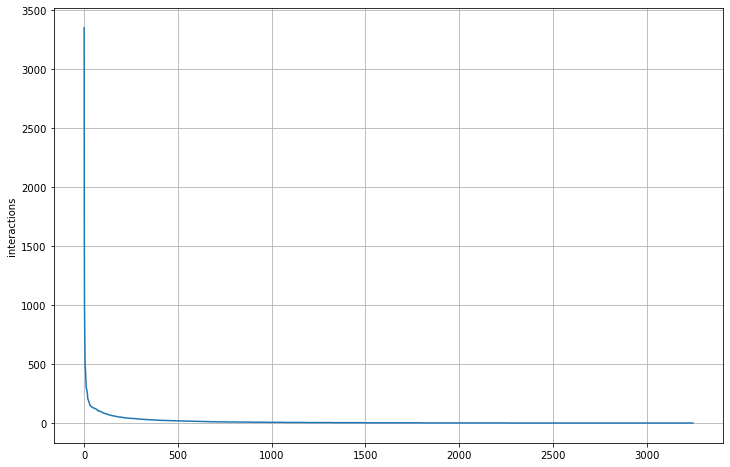

In [54]:
plt.figure(figsize=(12, 8))
sns.lineplot(
    x = [i for i in range(len(soma_interacoes_por_jogo_ordenado))],
    y = soma_interacoes_por_jogo_ordenado['interactions']
)
plt.grid()

### 3.3 A relação entre popularidade e frequencia de recomendação

Ao longo da historia da pesquisa em sistemas de recomendação um fato veio a tona: Os algoritmos possuem vieses naturalmente, em especifico para o vies de popularidade, notou-se que alguns algoritmos tendem a recomendar com mais frequencia aqueles filmes, jogos ou livros que são mais famosos, acarretando na retroalimentação (Feedback Loop) do vies de popularidade ("rich get richer").

Nessa etapa vamos visualizar como o modelo ``User-based KNN`` lida com esse vies! Para explorar isso vamos criar um modelo basico, treina-lo e gerar uma recomendação com o top-10 itens para cada usuario.

Além disso, vamos definir o conceito de ``frequencia de recomendação`` como a quantidade de vezes em que cada item é recomendado para todas as top-10 recomendações geradas. Por exemplo, se pro usuario 1 recomendamos os jogos A, B e C e para o usuario 2 recomendamos o jogo B e D, teremos que a frequencia de recomendação de B, $f(B) = 2$, enquanto que $f(A) = f(C) = f(D) = 1$

In [55]:
from  surprise.prediction_algorithms.slope_one import SlopeOne

reader = Reader(rating_scale = (0, 1))

trainset = Dataset.load_from_df(
    train[["user_id", "game_title", "hours_played"]], reader=reader
).build_full_trainset()

userknn = KNNBasic(K=10, sim_options={"user_based": True, "similarities": 'cosine'})
userknn.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


No bloco abaixo estamos calculando o score entre usuarios e jogos para selecionar os 10 itens com o maior score para cada usuario

In [56]:
new_predictions = []
prediction_user_map = {}
data_p2 = []

for user in tqdm.tqdm(test['user_id'].unique()[:500]):
    data = {"game_title": list(set(df["game_title"].unique()))}
    user_testset_df = pd.DataFrame(data)
    user_testset_df["hours_played"] = 0.0
    user_testset_df["user_id"] = user
    
    testset = (
        Dataset.load_from_df(
            user_testset_df[["user_id", "game_title", "hours_played"]],
            reader=reader,
        )
        .build_full_trainset()
        .build_testset()
    )
    predictions = sorted(
        [(pred.iid, pred.est)for pred in userknn.test(testset) if ((pred.uid == user))],
        key=lambda x: x[1],reverse=True
    )
    new_predictions.append(predictions[:10])
    prediction_user_map[user] = predictions[:10]
    
    for j in predictions[:10]:
        if j[0] in map_id:
            data_p2.append(map_id[j[0]])
    


100%|█████████████████████████████████████████| 500/500 [01:04<00:00,  7.70it/s]


Text(0.5, 0, 'ID Filmes')

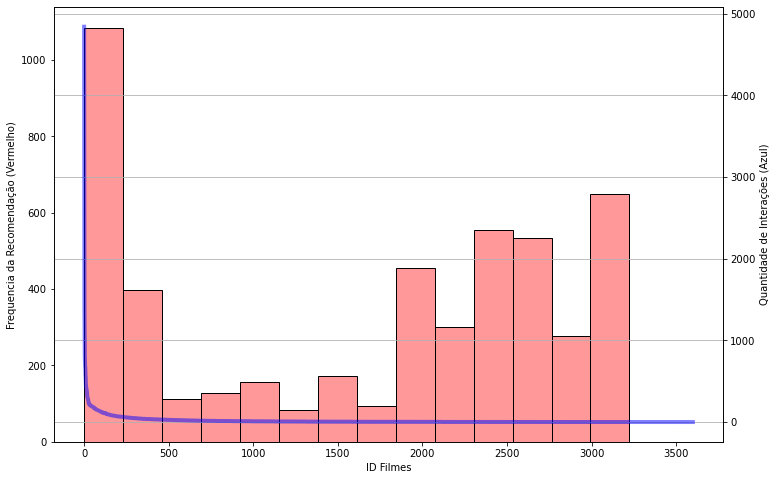

In [57]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 8))

g = sns.histplot(
    x = data_p2,color='red', alpha=0.4
)
plt.ylabel("Frequencia da Recomendação (Vermelho)")
plt.xlabel("ID Filmes")
ax2 = g.twinx()

plt.ylabel("Quantidade de Interações (Azul)")
sns.lineplot(
    x = [i for i in range(len(df['game_title'].unique()))],
    y=df.groupby('game_title').count().sort_values('hours_played', ascending=False)['hours_played'], ax=ax2,
    color='blue',linewidth = 4, alpha=0.5
)
plt.grid()
plt.xlabel("ID Filmes")

Na visualização acima temos a long-tail em azul, mostrando que poucos jogos concetram a maior parte das interações do dataset, porem, acrescentamos uma distribuição em vermelho, mostrando a quantidade acumulada que os itens foram recomendados para os usuarios.

Fica claro que existe uma correlação em que quanto mais popular o item (Azul), mais aparece o item nas listas de recomendação (Vermelho).

Esse é um exemplo classico em que os itens pouco popularidades do final da curva azul não são recomendados, sendo ignorados pelo dataset.

## 4. Formas de medir o vies de popularidade

Na etapa anterior foi possivel visualizar que existe uma correlação entre popularidade e a frequencia em que esses itens são recomendados, mas, precisamos medir esses efeitos de forma quantitativa para fazer comparações justas entre modelos de recomendação e algoritmos de debiasing

### 4.1 Popularidade média por grupo

Uma das formas de medir o impacto do vies de popularidade é por meio de uma metrica chamada GAP (Group Average Popularity). Essa métrica tem como objetivo agrupar usuarios em tres diferentes grupos:

* **Usuarios BlockBuster:** nesse caso os usuarios consomem majoritariamente jogos/filmes populares
* **Usuarios de Nicho:** Nessa categoria temos usuarios que consomem majoritariamente jogos/filmes pouco populares, como jogos indie e de nicho.
* **Usuarios de Diversidade:** Nessa categoria os usuarios consomem tanto populares quanto não populares

No entanto, para obter esses grupos, precisamos antes definir um criterio para dizer quais são os jogos populares ou não. Uma maneira de realizar essa divisão é utilizando a long tail curve que visualizamos anteriormente, de forma a dividi-la em 3 partes, sendo:
* **Head:** Grupo dos jogos que juntos somam 20% das maiores interações do dataset
* **Tail:** Grupo dos jogos que juntos somam 20% das menores interações do dataset
* **Mid:** Restante dos jogos que não entram em nenhum desses grupos.


Na cédula abaixo estamos somando as interações dos 11 filmes com maior interação do dataset e dividindo pela soma do total de interações. Observa-se que o resultado fica em $0.200823$, aproximadamente 20% ou seja, temos os itens que representam a HEAD da long tail curve, que compoem as 20% maiores interações

In [58]:
print(
    "% de interações: ",
    (soma_interacoes_por_jogo_ordenado.values[:11].sum()/soma_interacoes_por_jogo_ordenado.sum()
    ).values[0]
)

% de interações:  0.20082282842203397


Na cédula abaixo estamos somando as interações dos 2680 filmes com menor interação do dataset e dividindo pela soma do total de interações. Observa-se que o resultado fica em $0.20214$, aproximadamente 20% ou seja, temos os itens que representam a TAIL da long tail curve, que compoem as 20% menores interações

In [59]:
print(
    "% de interações: ",
    (soma_interacoes_por_jogo_ordenado.values[-2680:].sum()/soma_interacoes_por_jogo_ordenado.sum()
    ).values[0]
)

% de interações:  0.2021401645656844


Sabendo que os 11 primeiros filmes pertencem a HEAD e que os ultimos 2680 pertencem a TAIL, podemos definir uma variavel com o nome dos filmes e obter os filmes da categoria MID que não pertencem nem a HEAD nem a TAIL.

In [61]:
jogos_maior_20porcento_nome = soma_interacoes_por_jogo_ordenado.reset_index().values[:11, 0]
jogos_menor_20porcento_nome = soma_interacoes_por_jogo_ordenado.reset_index().values[-2680:, 0]

jogos_entre_os_20porcento = set(df['game_title']) - set(jogos_maior_20porcento_nome) - set(jogos_menor_20porcento_nome)

Após definir os items por categoria, vamos verificar em quais categorias cada usuario se encaixa. A verificação é simples:
* Consome mais que 50% de items da HEAD -> Usuario BlockBuster
* Consome mais que 50% de items da TAIL -> Usuario de Nicho
* Caso não seja nenhum dos dois anteriores -> Usuario de Diversidade

In [62]:
block_buster_group = []
niche_group = []
diverse_group = []

for user_id in train['user_id'].unique():
    interacted_by_user = train[train['user_id'] == user_id]
    high_pop = interacted_by_user[interacted_by_user['game_title'].isin(jogos_maior_20porcento_nome)]
    lowest_pop = interacted_by_user[interacted_by_user['game_title'].isin(jogos_menor_20porcento_nome)]

    if len(high_pop)/len(interacted_by_user) > 0.5:
        block_buster_group.append(user_id)
    elif len(lowest_pop)/len(interacted_by_user) > 0.5:
        niche_group.append(user_id)
    else:
        diverse_group.append(user_id)

In [63]:
def calculate_gap_profile(train, user_id):
    list_items = train[train['user_id'] == user_id]['game_title'].values
    gap = sum([map_soma[i] for i in list_items])
    return gap/len(list_items)
    
    
gap_bb_profile = np.mean([calculate_gap_profile(train, i) for i in block_buster_group])
gap_n_profile = np.mean([calculate_gap_profile(train, i) for i in niche_group])
gap_d_profile = np.mean([calculate_gap_profile(train, i) for i in diverse_group])

In [64]:
def calculate_gap(list_items):
    gap = sum([map_soma.get(i, 0) for i in list_items])
    return gap/len(list_items)

gap_bb_rec1 = 0
gap_d_rec1 = 0
gap_n_rec1 = 0

n_bb, n_d, n_n = 0, 0, 0

for user, reclist in zip(tqdm.tqdm(test['user_id'].unique()), new_predictions):
    if user in block_buster_group:
        n_bb += 1
        gap_bb_rec1 += calculate_gap([i[0] for i in reclist])
    elif user in niche_group:
        n_n += 1
        gap_n_rec1 += calculate_gap([i[0] for i in reclist])
    else:
        n_d += 1
        gap_d_rec1 += calculate_gap([i[0] for i in reclist])

gap_bb_rec1 = gap_bb_rec1/n_bb
gap_d_rec1 = gap_d_rec1/n_d
gap_n_rec1 = gap_n_rec1/n_n

  9%|███▎                                  | 500/5681 [00:00<00:00, 8270.51it/s]


In [65]:
delta_gab_bb = (gap_bb_rec1 - gap_bb_profile )/gap_bb_profile
delta_gab_d = (gap_d_rec1 - gap_d_profile )/gap_d_profile
delta_gab_n = (gap_n_rec1 - gap_n_profile )/gap_n_profile

delta_gab_bb, delta_gab_d, delta_gab_n

(-0.9606747642982831, -0.7902001610383613, 2.0903109638916035)

### 4.2 MRR

Algumas métricas interessante de visualizar quando lidamos com viés de popularidade são as métricas relacionadas a precisão da recomendação. Sabe-se pela literatura que a redução do víes de popularidade tem como efeito colateral a redução das métricas de precisão.

Para medir esse efeito utilizaremos a métrica Mean Rank Miscalibration. Essa métrica é baseada na posição do primeiro item relevante pra cada usuario.

Abaixo temos a equação para o calculo dessa medida. A função $relevant(i,j)$ retorna 1 se o item $j$ for relevante pro usuario $i$ e retorna 0 caso contrario. Aqui definimos como relevante um item que o usuario interagiu anteriormente.

$$MRR = \frac{1}{M} \sum_{i=1}^{M} \sum_{j=1}^{N} \frac{1}{j}\cdot relevant(i,j) $$

A figura abaixo deixa claro o funcionamento da métricas. Veja para o primeiro usuario, temos que somente o 3 item é o relevante, portanto, teremos $RR = \frac{1}{3}$ e assim por diante, realizando a média ao final dos calculos.


![alt text](images/mrr.png "Title")

In [68]:
def item_is_relevant(user_id, item_id):
    aux = df[df["user_id"] == user_id]
    if item_id in list(aux['game_title']):
        return True
    return False

def calculate_MRR(map_recommendations):

    MRR = 0
    for user_id in map_recommendations:
        user_find_corerect_item = False
        for index, (item, score) in enumerate(map_recommendations[user_id]):
            if user_find_corerect_item is False:
                if item_is_relevant(user_id, item):
                    MRR += (1/(index+1))
                    user_find_corerect_item = True
        
    return MRR/len(map_recommendations)

In [69]:
MRR_before = calculate_MRR(prediction_user_map)
MRR_before

0.14841587301587308

## 5. Correção do víes de popularidade

Conseguimos visualizar a problematica do vies de popularidade, medimos seu efeito de forma quantitativas, mas, e agora? Como pode evita-lo?

Existem inumeros métodos na literatura, mas, abordaremos um caso simples, proposto por [Nome Abdoula], em que é aplicado para os scores de cada item a seguinte heuristica:

$$
\hat{r_{ui}} = (1-\alpha)\cdot r_{ui} + \alpha \cdot \frac{1}{log(p(i))}
$$

Essa heuristica penaliza items que possuem muitas interações, pois, adiciona mais pontos ao score do item baseado em um calculo que é inversamente proporsional a quantidade de interações! Além disso, essa tecnica possui um parametro $\alpha$ que permite controlar o quanto queremos considerar da popularidade ou do score do modelo, ou seja, um $\alpha$ grande tende a penalizar muito itens populares enquanto que $\alpha$ pequeno tende a privilegiar itens populares.

Imagine que para o usuario $u$ nosso sistema recomendou os itens A e B, sendo o score de A $r_{uA} = 5$ e o score de B $r_{uB} = 4$, porem a popularidade de A é $p(A) = 10000$ e a popularidade de B é $p(B) = 10$, se aplicarmos essa correção com $alpha=0.5$, teremos que o novo score de A será $\hat{r_{uA}} = 2.75$ enquanto que o novo score de B será $\hat{r_{uB}} = 3$, ou seja, apesar de B ter um score inicial menor, por estarmos privilegiando itens menos popularidades seu novo score é maior, sendo ele escolhido para compor a lista de recomendação!

In [81]:
new_predictions_after = []
data_p2_after = []
prediction_user_map_after = {}

alpha = 0.1    

for user in tqdm.tqdm(test['user_id'].unique()[:500]):
    data = {"game_title": list(set(df["game_title"].unique()))}
    user_testset_df = pd.DataFrame(data)
    user_testset_df["hours_played"] = 0.0
    user_testset_df["user_id"] = user
    
    testset = (
        Dataset.load_from_df(
            user_testset_df[["user_id", "game_title", "hours_played"]],
            reader=reader,
        )
        .build_full_trainset()
        .build_testset()
    )
    predictions = sorted(
        [(pred.iid, (1-alpha)*pred.est + (alpha/np.log(map_soma.get(pred.iid, 1)+1)) )for pred in userknn.test(testset) if ((pred.uid == user))],
        key=lambda x: x[1],reverse=True
    )
    new_predictions_after.append(predictions[:10])
    prediction_user_map_after[user] = predictions[:10]
    
    for j in predictions[:10]:
        if j[0] in map_id:
            data_p2_after.append(map_id[j[0]])

100%|█████████████████████████████████████████| 500/500 [01:03<00:00,  7.91it/s]


### 5.1 Relação entre popularidade e frequencia pós debiasing 

Após corrigir a popularidade das recomendações, podemos olhar o grafico abaixo e verificar que houve uma mudança na distribuição das recomendações. O Primeiro grafico que vimos mostra um acumulo de recomendações nos itens mais populares, enquanto que, nesse segundo grafico fica claro que a distribuição está se concentrando nos filmes menos populares.

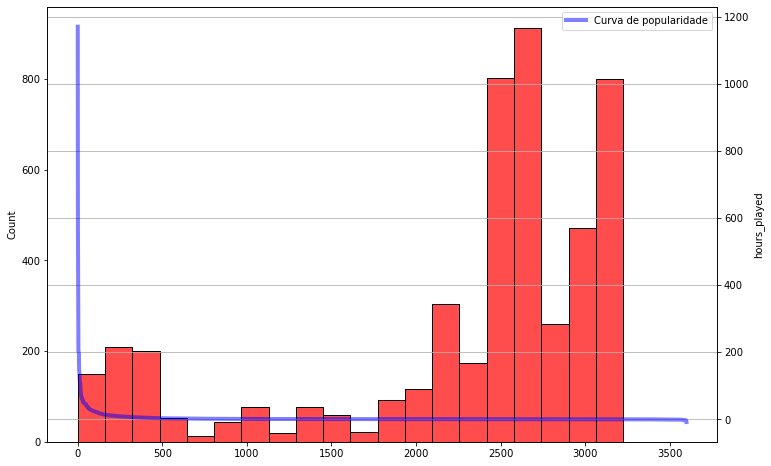

In [95]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 8))

g = sns.histplot(
    x = data_p2_after,color='red', label='Porcentagem de Recomendações - Debiased', alpha=0.7, bins=20
)


ax2 = g.twinx()

sns.lineplot(
    x = [i for i in range(len(df['game_title'].unique()))],
    y=df.groupby('game_title').sum().sort_values('hours_played', ascending=False)['hours_played'], ax=ax2,
    color='blue', label="Curva de popularidade", linewidth = 4, alpha=0.5
)
plt.grid()
plt.legend()
plt.show()

# 6. Comparação das métricas

Após aplicar os métodos de redução dos vies de popularidade, cabe comparar as métricas entre as recomendações considerando ou não a utilização do método de debiasing

In [96]:
gap_bb_rec1 = 0
gap_d_rec1 = 0
gap_n_rec1 = 0

n_bb, n_d, n_n = 0, 0, 0

for user, reclist in zip(tqdm.tqdm(test['user_id'].unique()[:500]), new_predictions_after):
    if user in block_buster_group:
        n_bb += 1
        gap_bb_rec1 += calculate_gap([i[0] for i in reclist])
    elif user in niche_group:
        n_n += 1
        gap_n_rec1 += calculate_gap([i[0] for i in reclist])
    else:
        n_d += 1
        gap_d_rec1 += calculate_gap([i[0] for i in reclist])

gap_bb_rec1_after = gap_bb_rec1/n_bb
gap_d_rec1_after = gap_d_rec1/n_d
gap_n_rec1_after = gap_n_rec1/n_n

100%|███████████████████████████████████████| 500/500 [00:00<00:00, 7390.92it/s]


In [97]:
delta_gab_bb_after = (gap_bb_rec1_after - gap_bb_profile )/gap_bb_profile
delta_gab_d_after = (gap_d_rec1_after - gap_d_profile )/gap_d_profile
delta_gab_n_after = (gap_n_rec1_after - gap_n_profile )/gap_n_profile

delta_gab_bb_after, delta_gab_d_after, delta_gab_n_after

(-0.9770115604168048, -0.9004123039212548, -0.6489368534064408)

Calculando a métricas MRR para as recomendações "corrigidas"

In [86]:
MRR_after = calculate_MRR(prediction_user_map_after)
MRR_after

0.04463968253968253

## 6.1 Comparação entre GAP

No grafico abaixo, podemos ver que o método de debiasing (Azul) reduziu a popularidade média de todos os grupos, ou seja, utilizando esse método estamos recomendando items menos popularidades que se utilizando apenas o resultado do modelo de recomendação.

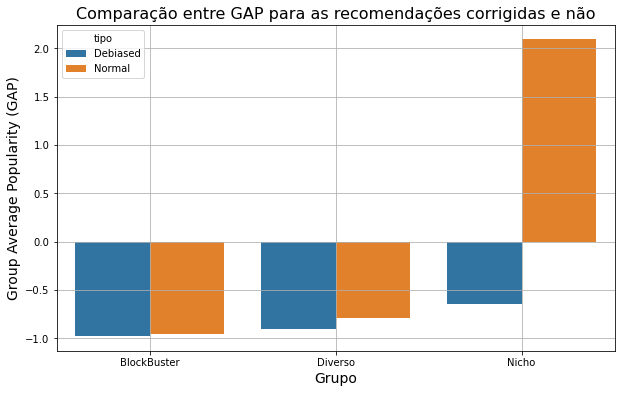

In [101]:
gap_data = pd.DataFrame(
    {
        'GAP': [delta_gab_bb_after, delta_gab_d_after, delta_gab_n_after] + [delta_gab_bb, delta_gab_d, delta_gab_n],
        'tipo': ['Debiased', 'Debiased','Debiased', "Normal", "Normal", "Normal"],
        'Grupo': ['BlockBuster', "Diverso", "Nicho", 'BlockBuster', "Diverso", "Nicho"]
    }
)
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=gap_data['Grupo'],
    y=gap_data['GAP'],
    hue=gap_data['tipo']
)
plt.xlabel("Grupo", fontsize=14)
plt.ylabel("Group Average Popularity (GAP)", fontsize=14)
plt.title("Comparação entre GAP para as recomendações corrigidas e não", fontsize=16)
plt.grid()

## 6.2 Comparação entre MRR

No grafico abaixo, podemos ver que o método de debiasing (Azul) reduziu a precisão (MRR) se comparado a lista de recomendação sem a utilização desse método. 

Como dissemos anteriormente, os métodos de debiasing de vies de popularidade são conhecidos por reduzir a precisão da recomendação, que condiz com o visualizado abaixo.

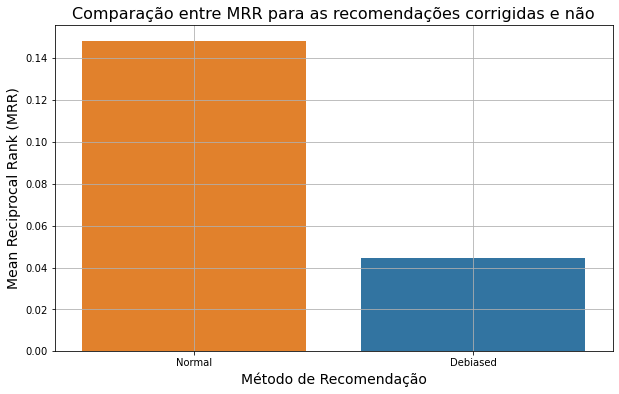

In [111]:
gap_data = pd.DataFrame(
    {
        'MRR': [MRR_before, MRR_after,],
        'tipo': ["Normal", 'Debiased'],
    }
)
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=gap_data['tipo'],
    y=gap_data['MRR'],
    palette=[sns.color_palette()[1], sns.color_palette()[0]]
)
plt.xlabel("Método de Recomendação", fontsize=14)
plt.ylabel("Mean Reciprocal Rank (MRR)", fontsize=14)
plt.title("Comparação entre MRR para as recomendações corrigidas e não", fontsize=16)
plt.grid()

## 7. Referencias para Aprofundamento

Vieses é um tempo importante discutido dentro de sistemas de recomendação, nos ultimos anos tem crescido o numero de artigos publicos sobre o tema. Nesse notebook, abordamos o vies aplicado a popularidade de itens, mas existem inumeros vieses e formas diferente de corrigi-los.

Um bom primeiro passa para aprofundamento é o artigo de Jiawei Chen:

Bias and Debias in Recommender System: A Survey and Future Directions (https://arxiv.org/pdf/2010.03240.pdf)

Para se aprofundar em vieses de popular é o artigo de Mehdi Elahi:

Investigating the impact of recommender systems on user-based and item-based popularity bias (https://www.sciencedirect.com/science/article/pii/S0306457321001436)
